## **BCI Competition III Dataset IV**

#### **1. Load training and test dataset**

In [2]:
import os
import pandas as pd
import numpy as np

data_path = os.path.join(os.getcwd(), "..", "data", "bci_competition")
data_psd_path = os.path.join(data_path, "data_psd")

# Channel indices for left and right brain
left_channels = [0, 36, 60]  # C3, CP1, P3
right_channels = [24, 48, 84]  # C4, CP2, P4

def load_psd_file(file_path, include_labels=True):
    """
    Load a PSD file and extract features and labels     
    """
    data = pd.read_csv(file_path, delim_whitespace=True, header=None)
    features = data.iloc[:, :96]
    labels = data.iloc[:, 96] if include_labels else None
    return features, labels



#### **2. Extract left and right regions (electrodes)**

The dataset has 96 PSD features (12 frequency bands for 8 channels). We need to extract the left and right brain regions.

Left channels: **[C3, CP1, CP5, P3]** → 4 channels → 4×12=48 features.
Right channels: **[C4, CP2, CP6, P4]** → 4 channels → also 48 features.

In [3]:
def extract_left_right_features(features):
    """
    Extract left and right brain features from the PSD data.
    """
    left_features = pd.concat([features.iloc[:, i:i+12] for i in left_channels], axis=1) # skip each 12 columns
    right_features = pd.concat([features.iloc[:, i:i+12] for i in right_channels], axis=1)
    return left_features, right_features

In [4]:
train_files = [f for f in os.listdir(data_psd_path) if f.startswith("train")]
train_data = {}
for file in train_files:
    file_path = os.path.join(data_psd_path, file)
    features, labels = load_psd_file(file_path)
    left_features, right_features = extract_left_right_features(features)
    train_data[file] = (left_features, right_features, labels)

train_left = pd.concat([data[0] for data in train_data.values()])
train_right = pd.concat([data[1] for data in train_data.values()])
train_labels = pd.concat([data[2] for data in train_data.values()])



C:\Users\anaca\AppData\Local\Temp\ipykernel_31828\962179718.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)
C:\Users\anaca\AppData\Local\Temp\ipykernel_31828\962179718.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)
C:\Users\anaca\AppData\Local\Temp\ipykernel_31828\962179718.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)
C:\Users\anaca\AppData\Local\Temp\ipykernel_31828\962179718.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a fu

#### **3. Resample to get predictions every 0.5 seconds**

As mentioned in the competition, we need to average every 8 consecutive samples to predict the task every 0.5 seconds (since the sampling rate is 16 Hz, each 8 samples correspond to 0.5 seconds).

In [5]:
def resample_features(features, step=8):
    """ 
    Resample features by averaging over intervals of 0.5s.
    """
    num_samples = len(features)
    num_intervals = num_samples // step
    resampled = np.mean(features[:num_intervals * step].values.reshape(-1, step, features.shape[1]), axis=1)
    return pd.DataFrame(resampled)

train_left_resampled = resample_features(train_left)
train_right_resampled = resample_features(train_right)

xt = train_left_resampled  # Left electrode features
yt = train_right_resampled  # Right electrode features


#### **4. Combine and prepare for the Adaptive CCA Alg.**

**x_t**: (36-dimensional feature vector).
**y_t**: (class labels) for each time interval.

In [6]:
print("xt shape:", xt.shape)  
print("yt shape:", yt.shape)  
np.save("xt.npy", xt)
np.save("yt.npy", yt)

xt shape: (3902, 36)
yt shape: (3902, 36)


#### **6. Adaptive CCA Implemented**

##### **A. Preprocessing**

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

xt = np.load("xt.npy")  # left hemisphere features (n_samples, 36)
yt = np.load("yt.npy")  # right hemisphere features (n_samples, 36)

# Preprocess (normalize)
xt = (xt - np.mean(xt, axis=0)) / np.std(xt, axis=0)
yt = (yt - np.mean(yt, axis=0)) / np.std(yt, axis=0)

n_samples, nx = xt.shape
_, ny = yt.shape
p = 4  # Rank of decomposition (number of principal directions)
beta = 0.98  # Forgetting factor, test with 0.99, 0.98, 0.95


##### **B. Computing the CCA model**

Computation of the algorithm based on suggested steps.

--------------------------------------------------

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def initialize_covariance_matrices(xt, yt, n_init_samples):
    """
    Initialize the covariance matrices using the first n_init_samples.
    """
    Cx = np.cov(xt[:n_init_samples], rowvar=False)
    Cy = np.cov(yt[:n_init_samples], rowvar=False)
    Cxy = np.cov(xt[:n_init_samples].T, yt[:n_init_samples].T)[:xt.shape[1], xt.shape[1]:]
    return Cx, Cy, Cxy

def adap_cca_algorithm1(xt, yt, beta=0.98, p=4, threshold_percentile=90, step_size=0.01, n_init_samples=100):
    """
    Adaptive CCA algorithm based on Algorithm 1, including proper covariance initialization, 
    change detection, and reconstruction error computation.
    """
    n_samples, nx = xt.shape
    _, ny = yt.shape

    # Initialize covariance matrices
    Cx, Cy, Cxy = initialize_covariance_matrices(xt, yt, n_init_samples)

    # Initialize U and V as random orthonormal matrices
    U = np.random.randn(nx, p)
    V = np.random.randn(ny, p)
    U, _ = np.linalg.qr(U)  # Orthonormalize
    V, _ = np.linalg.qr(V)

    reconstruction_errors = []
    detected_changes = []

    for t in range(n_samples):
        x_t = xt[t].reshape(-1, 1)
        y_t = yt[t].reshape(-1, 1)

        # Compute compressed samples
        zx = U.T @ x_t
        zy = V.T @ y_t

        # Compute the compressed autocovariance matrices
        G_x = beta * np.eye(p) + zx @ zx.T
        G_y = beta * np.eye(p) + zy @ zy.T

        # Compute initial matrices Ou, Ov
        alpha_x = (zx.T @ zx) / (beta * (1 + zx.T @ zx))
        px = 1 - np.sqrt(1 / (1 + alpha_x))
        Ou = beta**(-0.5) * (np.eye(p) - px * (zx @ zx.T) / (zx.T @ zx))

        alpha_y = (zy.T @ zy) / (beta * (1 + zy.T @ zy))
        py = 1 - np.sqrt(1 / (1 + alpha_y))
        Ov = beta**(-0.5) * (np.eye(p) - py * (zy @ zy.T) / (zy.T @ zy))

        # ---------------Compute the gradient ascent----------------
        # New subspace matrices
        U_tprima = U @ Ou
        V_tprima = V @ Ov

        L_tprima = U_tprima.T @ Cxy @ V_tprima  # Shape: (p, p)
        L_t = U.T @ Cxy @ V  # Shape: (p, p)
        N = np.diag(np.linspace(0, 1, p))  # Shape: (p, p). Brockett matrix

        print("Cx shape:", Cx.shape)
        print("Cy shape:", Cy.shape)
        print("Cxy shape:", Cxy.shape)
        print("L shape:", L_t.shape)
        print("N shape:", N.shape)
        print("Ou shape:", Ou.shape)
        print("V shape:", V.shape)
        print("U shape:", U.shape)

        inverse = np.linalg.inv(Cx)
        first_term = inverse @ L_t
        first_term = first_term @ Ov
        first_term = first_term @ N
        second_term = 0.5 * Ou @ L_t @ N
        third_term = 0.5 * U @ Ou @ N @ L_t.T
        grad_U = first_term - second_term - third_term

        first_termy = np.linalg.inv(Cy) @ L_t @ Ou @ N
        second_termy = 0.5 * Ov @ L_t @ N
        third_termy = 0.5 * V @ Ov @ N @ L_t.T
        grad_V = first_termy - second_termy - third_termy

        # grad_U = (np.linalg.inv(Cx) @ L_t @ Ov @ N - 0.5 * Ou @ L_t @ N - 0.5 * U @ Ou @ N @ L_t.T)
        # grad_V = (np.linalg.inv(Cy) @ L_t @ Ou @ N - 0.5 * Ov @ L_t @ N - 0.5 * V @ Ov @ N @ L_t.T)

        # Update U and V
        U += step_size * grad_U
        V += step_size * grad_V

        # Normalize U and V
        U, _ = np.linalg.qr(U)
        V, _ = np.linalg.qr(V)

        # Update covariance matrices adaptively
        if t >= n_init_samples:
            Cx = beta * Cx + x_t @ x_t.T
            Cy = beta * Cy + y_t @ y_t.T
            Cxy = beta * Cxy + x_t @ y_t.T

        # Compute residuals
        fx = np.linalg.inv(Cx) @ x_t - U @ zx
        fy = np.linalg.inv(Cy) @ y_t - V @ zy

        # Perform adapted gradient ascent
        bar_zx = zx - (zx.T @ N @ zy) / (zy.T @ N @ N @ zy) * zy
        bar_alpha_x = (fx.T @ Cx @ fx + bar_zx.T @ bar_zx) / 4 * (zy.T @ N @ N @ zy) * step_size**2
        bar_px = 1 - np.sqrt(1 / (1 + bar_alpha_x))

        U += step_size * ((1 - px) * fx @ zy.T @ N + 0.5 * (1 - px) * U @ bar_zx @ zy.T @ N
                          - 0.5 * (1 - bar_px) * U @ N @ zy @ bar_zx.T)
        V += step_size * ((1 - py) * fy @ zx.T @ N + 0.5 * (1 - py) * V @ bar_zx @ zx.T @ N
                          - 0.5 * (1 - bar_px) * V @ N @ zx @ bar_zx.T)

        # Compute reconstruction error
        c_t = 0.5 * (fx.T @ Cx @ fx / nx + fy.T @ Cy @ fy / ny)
        if c_t.item() > 0.2:
            print("Reconstruction error:", c_t.item())
        else:
            reconstruction_errors.append(c_t.item())

        # Detect changes based on a threshold
        if t > n_init_samples + 5:  # Ensure enough samples to compute a stable threshold
            threshold = np.percentile(reconstruction_errors[:t], threshold_percentile)
            if reconstruction_errors[-1] > threshold:
                if len(detected_changes) == 0 or (t - detected_changes[-1] > 5):
                    detected_changes.append(t)

    return reconstruction_errors, detected_changes

def plot_reconstruction_errors(reconstruction_errors, detected_changes, ground_truth_interval=500, with_changes=True):
    """
    Plot reconstruction errors with detected and true change points.
    """
    plt.figure(figsize=(12, 6))
    x = np.arange(len(reconstruction_errors))

    # Plot reconstruction errors
    plt.plot(x, reconstruction_errors, label="Reconstruction Error", color='blue')

    # Plot detected changes
    if with_changes:
        for change in detected_changes:
            plt.axvline(change, color='orange', linestyle='--', label="Detected Change" if change == detected_changes[0] else "")

    # Plot ground truth change points
    for truth in range(0, len(reconstruction_errors), ground_truth_interval):
        plt.axvline(truth, color='red', linestyle='dashed', label="Ground Truth" if truth == 0 else "")

    # Add threshold line
    threshold = np.percentile(reconstruction_errors, 90)
    plt.axhline(threshold, color='black', linestyle='dotted', label="Threshold")

    plt.xlabel("Time (ms)")
    plt.ylabel("Reconstruction Error")
    plt.title("Reconstruction Error and Detected Changes")
    plt.legend()
    plt.grid(True)
    plt.show()


In [27]:
def adap_cca_algorithm2(xt, yt, beta=0.98, p=4, threshold_percentile=90, step_size=0.01, n_init_samples=100):
    """
    Adaptive CCA algorithm based on Algorithm 1, including proper covariance initialization,
    change detection, and reconstruction error computation.
    """
    n_samples, nx = xt.shape
    _, ny = yt.shape

    # Initialize covariance matrices
    Cx, Cy, Cxy = initialize_covariance_matrices(xt, yt, n_init_samples)

    # Initialize U and V as random orthonormal matrices
    U = np.random.randn(nx, p)
    V = np.random.randn(ny, p)
    U, _ = np.linalg.qr(U)  # Orthonormalize
    V, _ = np.linalg.qr(V)

    reconstruction_errors = []
    detected_changes = []

    for t in range(n_samples):
        x_t = xt[t].reshape(-1, 1)
        y_t = yt[t].reshape(-1, 1)

        # Compute compressed samples
        zx = U.T @ x_t
        zy = V.T @ y_t

        # Compute the compressed autocovariance matrices
        G_x = beta * np.eye(p) + zx @ zx.T
        G_y = beta * np.eye(p) + zy @ zy.T

        # Compute initial matrices Ou, Ov
        alpha_x = (zx.T @ zx) / (beta * (1 + zx.T @ zx))
        px = 1 - np.sqrt(1 / (1 + alpha_x))
        Ou = beta**(-0.5) * (np.eye(p) - px * (zx @ zx.T) / (zx.T @ zx))

        alpha_y = (zy.T @ zy) / (beta * (1 + zy.T @ zy))
        py = 1 - np.sqrt(1 / (1 + alpha_y))
        Ov = beta**(-0.5) * (np.eye(p) - py * (zy @ zy.T) / (zy.T @ zy))

        # ---------------Compute the gradient ascent----------------
        # New subspace matrices
        U_tprima = U @ Ou
        V_tprima = V @ Ov

        L_tprima = U_tprima.T @ Cxy @ V_tprima  # Shape: (p, p)
        L_t = U.T @ Cxy @ V  # Shape: (p, p)
        N = np.diag(np.linspace(0, 1, p))  # Shape: (p, p). Brockett matrix

        # Compute gradients for U and V
        inverse_Cx = np.linalg.inv(Cx)
        first_term_U = inverse_Cx @ L_t @ Ov @ N
        second_term_U = 0.5 * Ou @ L_t @ N
        third_term_U = 0.5 * U @ Ou @ N @ L_t.T
        grad_U = first_term_U - second_term_U - third_term_U

        inverse_Cy = np.linalg.inv(Cy)
        first_term_V = inverse_Cy @ L_t @ Ou @ N
        second_term_V = 0.5 * Ov @ L_t @ N
        third_term_V = 0.5 * V @ Ov @ N @ L_t.T
        grad_V = first_term_V - second_term_V - third_term_V

        # Update U and V
        U += step_size * grad_U
        V += step_size * grad_V

        # Normalize U and V
        U, _ = np.linalg.qr(U)
        V, _ = np.linalg.qr(V)

        # Second gradient ascent step for further refinement
        # Re-compute compressed samples after first update
        zx = U.T @ x_t
        zy = V.T @ y_t

        # Repeat the calculation of G_x and G_y with updated U and V
        G_x = beta * np.eye(p) + zx @ zx.T
        G_y = beta * np.eye(p) + zy @ zy.T

        # Recompute Ou and Ov after first update
        alpha_x = (zx.T @ zx) / (beta * (1 + zx.T @ zx))
        px = 1 - np.sqrt(1 / (1 + alpha_x))
        Ou = beta**(-0.5) * (np.eye(p) - px * (zx @ zx.T) / (zx.T @ zx))

        alpha_y = (zy.T @ zy) / (beta * (1 + zy.T @ zy))
        py = 1 - np.sqrt(1 / (1 + alpha_y))
        Ov = beta**(-0.5) * (np.eye(p) - py * (zy @ zy.T) / (zy.T @ zy))

        # Compute gradients again for U and V
        L_tprima = U.T @ Cxy @ V  # L_t is now updated
        first_term_U = inverse_Cx @ L_t @ Ov @ N
        second_term_U = 0.5 * Ou @ L_t @ N
        third_term_U = 0.5 * U @ Ou @ N @ L_t.T
        grad_U = first_term_U - second_term_U - third_term_U

        first_term_V = inverse_Cy @ L_t @ Ou @ N
        second_term_V = 0.5 * Ov @ L_t @ N
        third_term_V = 0.5 * V @ Ov @ N @ L_t.T
        grad_V = first_term_V - second_term_V - third_term_V

        # Update U and V again
        U += step_size * grad_U
        V += step_size * grad_V

        # Normalize U and V after the second update
        U, _ = np.linalg.qr(U)
        V, _ = np.linalg.qr(V)

        # Update covariance matrices adaptively
        if t >= n_init_samples:
            Cx = beta * Cx + x_t @ x_t.T
            Cy = beta * Cy + y_t @ y_t.T
            Cxy = beta * Cxy + x_t @ y_t.T

            # Compute residuals
            fx = np.linalg.inv(Cx) @ x_t - U @ zx
            fy = np.linalg.inv(Cy) @ y_t - V @ zy

            # Compute reconstruction error
            c_t = 0.5 * (fx.T @ Cx @ fx / nx + fy.T @ Cy @ fy / ny)
            reconstruction_errors.append(c_t.item())

            # Detect changes based on a threshold
            if t > n_init_samples + 5:  # Ensure enough samples to compute a stable threshold
                threshold = np.percentile(reconstruction_errors[:t], threshold_percentile)
                if reconstruction_errors[-1] > threshold:
                    if len(detected_changes) == 0 or (t - detected_changes[-1] > 5):
                        detected_changes.append(t)

    return reconstruction_errors, detected_changes

In [28]:
rec_errors, det_changes = adap_cca_algorithm2(xt, yt, beta=0.98, p=4, threshold_percentile=90, step_size=0.01, n_init_samples=100)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 36)

In [18]:
import numpy as np

def adaptive_cca(xt, yt, beta=0.98, step_size=0.01):
    """
    Adaptive CCA Algorithm following the described steps
    """
    n_samples, nx = xt.shape
    _, ny = yt.shape
    p = U.shape[1]  # Number of components
    
    # Initialize covariance matrices
    Cx = np.eye(nx)
    Cy = np.eye(ny)
    Cxy = np.zeros((nx, ny))

    Cx = np.eye(nx)
    Cy = np.eye(ny)
    Cxy = np.zeros((nx, ny))

   
    
    for t in range(n_samples):
        x_t = xt[t].reshape(-1, 1)
        y_t = yt[t].reshape(-1, 1)
        
        # Compute compressed samples
        zx = U.T @ x_t
        zy = V.T @ y_t
        
        # Compute coefficients
        alpha_x = (zx.T @ zx) / (beta * (1 + zx.T @ zx))
        alpha_y = (zy.T @ zy) / (beta * (1 + zy.T @ zy))
        px = 1 - np.sqrt(1 / (1 + alpha_x))
        py = 1 - np.sqrt(1 / (1 + alpha_y))
        
        # Compute initial matrices Ou and Ov
        Ou = (beta ** -0.5) * (np.eye(p) - px * (zx @ zx.T) / (zx.T @ zx))
        Ov = (beta ** -0.5) * (np.eye(p) - py * (zy @ zy.T) / (zy.T @ zy))
        
        # Compute Brockett gradient ascent
        L = U.T @ Cxy @ V
        N = np.diag(np.linspace(0.1, 1, p))  # Example diagonal matrix N
        Gx_inv = np.linalg.inv(U.T @ Cx @ U)
        Gy_inv = np.linalg.inv(V.T @ Cy @ V)
        
        chi_Ou = Gx_inv @ L @ Ov @ N - 0.5 * Ou @ L @ N - 0.5 * Ou @ N @ L.T
        chi_Ov = Gy_inv @ L.T @ Ou @ N - 0.5 * Ov @ L.T @ N - 0.5 * Ov @ N @ L
        
        U += step_size * chi_Ou @ U
        V += step_size * chi_Ov @ V
        
        # Update covariance matrices
        Cx = beta * Cx + (1 - beta) * x_t @ x_t.T
        Cy = beta * Cy + (1 - beta) * y_t @ y_t.T
        Cxy = beta * Cxy + (1 - beta) * x_t @ y_t.T
        
        # Compute residuals
        fx = np.linalg.inv(Cx) @ x_t - U @ zx
        fy = np.linalg.inv(Cy) @ y_t - V @ zy
        
        # Compute adapted gradient descent
        chi_U = fx @ zy.T @ N + 0.5 * U @ (zx @ zy.T @ N - N @ zy @ zx.T)
        chi_V = fy @ zx.T @ N + 0.5 * V @ (zy @ zx.T @ N - N @ zx @ zy.T)
        
        # Compute adjusted coefficients for final update
        alpha_x_bar = (fx.T @ Cx @ fx + zx.T @ zx) / 4 * (zy.T @ N @ N @ zy) * step_size**2
        px_bar = 1 - np.sqrt(1 / (1 + alpha_x_bar))
        zx_bar = zx - (zx.T @ N @ zy) / (zy.T @ N @ N @ zy) * zy
        
        # Update U and V
        U -= px * U @ (N @ zy @ zy.T @ N) / (zy.T @ N @ N @ zy)
        U += px_bar * U @ (zx_bar @ zx_bar.T) / (zx_bar.T @ zx_bar)
        U += step_size * (1 - px) * fx @ zy.T @ N
        U += 0.5 * step_size * (1 - px) * U @ zx_bar @ zy.T @ N
        U -= 0.5 * step_size * (1 - px_bar) * U @ N @ zy @ zx_bar.T
        
        V -= py * V @ (N @ zx @ zx.T @ N) / (zx.T @ N @ N @ zx)
        V += py * V @ (zy @ zy.T) / (zy.T @ zy)
        V += step_size * (1 - py) * fy @ zx.T @ N
        V += 0.5 * step_size * (1 - py) * V @ zy @ zx.T @ N
        V -= 0.5 * step_size * (1 - py) * V @ N @ zx @ zy.T
        
    return U, V, Cx, Cy, Cxy


In [17]:
def adap_cca(xt, yt, beta=0.98, p=4, threshold_percentile=90) -> tuple:
    """
    Adaptive CCA algorithm for change detection between xt and yt.
    """
    Cx = np.eye(nx)  
    Cy = np.eye(ny)  
    Cxy = np.zeros((nx, ny)) 
    Cx_list = []
    Cy_list = []
    Cxy_list = []
    residuals_x = []
    residuals_y = []

    Ux = np.random.randn(nx, p)  # Random init
    Vy = np.random.randn(ny, p)
    Ux, _ = np.linalg.qr(Ux)  # Orthonormalize Ux
    Vy, _ = np.linalg.qr(Vy)  # Orthonormalize Vy

    reconstruction_errors = []
    detected_changes = []

    for t in range(n_samples):
        # Get the current sample (step t)
        x_t = xt[t].reshape(-1, 1)
        y_t = yt[t].reshape(-1, 1)

        # Update covariance matrices
        Cx = beta * Cx + (1 - beta) * x_t @ x_t.T
        Cy = beta * Cy + (1 - beta) * y_t @ y_t.T
        Cxy = beta * Cxy + (1 - beta) * x_t @ y_t.T

        # Compute generalized eigenvalue problem
        Mx = np.linalg.inv(Cx) @ Cxy @ np.linalg.inv(Cy) @ Cxy.T
        My = np.linalg.inv(Cy) @ Cxy.T @ np.linalg.inv(Cx) @ Cxy
        eig_vals_x, eig_vecs_x = np.linalg.eigh(Mx)
        eig_vals_y, eig_vecs_y = np.linalg.eigh(My)

        # Take top p components
        Ux = eig_vecs_x[:, -p:]
        Vy = eig_vecs_y[:, -p:]

        # Compute residuals
        rx_t = np.linalg.inv(Cx) @ (np.eye(nx) - Ux @ Ux.T) @ x_t
        ry_t = np.linalg.inv(Cy) @ (np.eye(ny) - Vy @ Vy.T) @ y_t

        residuals_x.append(rx_t.flatten())
        residuals_y.append(ry_t.flatten())

        # Compute reconstruction error
        c_t = 0.5 * (rx_t.T @ Cx @ rx_t / nx + ry_t.T @ Cy @ ry_t / ny)
        reconstruction_errors.append(c_t.item())

        # Detect changes (based on a threshold tau)
        if len(reconstruction_errors) > 5:
            if reconstruction_errors[-1] > np.percentile(reconstruction_errors[:t], threshold_percentile):
                if len(detected_changes) == 0 or (t - detected_changes[-1] > 5):
                    detected_changes.append(t)

    return reconstruction_errors, detected_changes, Cx_list, Cy_list, Cxy_list, residuals_x, residuals_y

reconstruction_errors, detected_changes, Cx_list, Cy_list, Cxy_list, residuals_x, residuals_y = adap_cca(xt, yt, beta=beta, p=p, threshold_percentile=90)


In [18]:
def adap_cca_synthetic(xt, yt, beta=0.99, p=5, threshold_percentile=95):
    """
    Standard adaptive CCA with exponentially weighted covariance matrices.
    """
    n_samples, x_dim = xt.shape
    _, y_dim = yt.shape

    # Initialize exponentially weighted covariance matrices
    Cxx = np.eye(x_dim) * 1e-6
    Cyy = np.eye(y_dim) * 1e-6
    Cxy = np.zeros((x_dim, y_dim))

    # Store reconstruction errors and detected change points
    recon_errors = []
    detected_changes = []

    for t in range(n_samples):
        # Get the current sample (step t)
        x_t = xt[t].reshape(-1, 1)
        y_t = yt[t].reshape(-1, 1)

        # Update covariance matrices
        Cxx = beta * Cxx + (1 - beta) * (x_t @ x_t.T)
        Cyy = beta * Cyy + (1 - beta) * (y_t @ y_t.T)
        Cxy = beta * Cxy + (1 - beta) * (x_t @ y_t.T)

        try:
            # Solve generalized eigenvalue problem for reconstruction error
            eigvals, eigvecs_x = np.linalg.eig(np.linalg.inv(Cxx) @ Cxy @ np.linalg.inv(Cyy) @ Cxy.T)
            eigvals = np.real(eigvals)  # Ensure eigenvalues are real
            recon_error = 1 - np.sum(eigvals[:p])
        except np.linalg.LinAlgError:
            # Handle any potential numerical issues
            recon_error = np.nan

        # Append valid errors only
        if np.isfinite(recon_error):
            recon_errors.append(recon_error)

        # Detect change points based on threshold
        if len(recon_errors) > 0:  # Ensure there's at least one valid error
            threshold = np.percentile(recon_errors, threshold_percentile)
            if recon_error > threshold:
                detected_changes.append(t)

    # Ensure function always returns valid outputs
    return recon_errors, detected_changes


#### **B.2 Stiefel formulation**

In [16]:
import numpy as np
from scipy.linalg import expm

def stiefel_geodesic_update(U, grad, step_size=0.01):
    """
    Perform a geodesic update on the Stiefel manifold using the exponential map.
    """
    skew_symmetric = grad @ U.T - U @ grad.T  # Ensure the update is skew-symmetric
    exp_update = expm(-step_size * skew_symmetric)  # Exponential map
    U_new = exp_update @ U
    return U_new

def adap_cca_stiefel(xt, yt, beta=0.98, p=4, threshold_percentile=90, step_size=0.01):
    """
    Adaptive CCA algorithm on Stiefel and Grassmann manifolds for change detection.
    """
    n_samples, nx = xt.shape
    _, ny = yt.shape

    Cx = np.eye(nx)
    Cy = np.eye(ny)
    Cxy = np.zeros((nx, ny))

    # Initialize Ux and Vy on the Stiefel manifold
    Ux = np.random.randn(nx, p)
    Vy = np.random.randn(ny, p)
    Ux, _ = np.linalg.qr(Ux)  # Orthonormalize
    Vy, _ = np.linalg.qr(Vy)

    reconstruction_errors = []
    detected_changes = []

    for t in range(n_samples):
        x_t = xt[t].reshape(-1, 1)
        y_t = yt[t].reshape(-1, 1)

        # Update covariance matrices
        Cx = beta * Cx + (1 - beta) * x_t @ x_t.T
        Cy = beta * Cy + (1 - beta) * y_t @ y_t.T
        Cxy = beta * Cxy + (1 - beta) * x_t @ y_t.T

        # Compute gradients on Stiefel manifold
        Mx = np.linalg.inv(Cx) @ Cxy @ np.linalg.inv(Cy) @ Cxy.T
        My = np.linalg.inv(Cy) @ Cxy.T @ np.linalg.inv(Cx) @ Cxy

        print("Shape of Ux: ", Ux.shape)
        print("Shape of Vy: ", Vy.shape)
        print("Shape of Mx: ", Mx.shape)
        print("Shape of My: ", My.shape)
        print("Shape of Cx: ", Cx.shape)
        print("Shape of Cy: ", Cy.shape)
        print("Shape of Cxy: ", Cxy.shape)

        grad_Ux = -Mx @ Ux + Ux @ (Ux.T @ Mx @ Ux)
        grad_Vy = -My @ Vy + Vy @ (Vy.T @ My @ Vy)

        # Update Ux and Vy using geodesic flows on the Stiefel manifold
        Ux = stiefel_geodesic_update(Ux, grad_Ux, step_size)
        Vy = stiefel_geodesic_update(Vy, grad_Vy, step_size)

        # Compute residuals
        rx_t = np.linalg.inv(Cx) @ (np.eye(nx) - Ux @ Ux.T) @ x_t
        ry_t = np.linalg.inv(Cy) @ (np.eye(ny) - Vy @ Vy.T) @ y_t

        # Compute reconstruction error
        c_t = 0.5 * (rx_t.T @ Cx @ rx_t / nx + ry_t.T @ Cy @ ry_t / ny)
        reconstruction_errors.append(c_t.item())

        # Detect changes based on a threshold
        if len(reconstruction_errors) > 5:
            if reconstruction_errors[-1] > np.percentile(reconstruction_errors[:t], threshold_percentile):
                if len(detected_changes) == 0 or (t - detected_changes[-1] > 5):
                    detected_changes.append(t)

    return reconstruction_errors, detected_changes


In [17]:
reconstruction_errors_stiefel, detected_changes_stiefel = adap_cca_stiefel(xt, yt, beta=beta, p=p, threshold_percentile=99, step_size=0.01)

Shape of Ux:  (36, 4)
Shape of Vy:  (36, 4)
Shape of Mx:  (36, 36)
Shape of My:  (36, 36)
Shape of Cx:  (36, 36)
Shape of Cy:  (36, 36)
Shape of Cxy:  (36, 36)
Shape of Ux:  (36, 4)
Shape of Vy:  (36, 4)
Shape of Mx:  (36, 36)
Shape of My:  (36, 36)
Shape of Cx:  (36, 36)
Shape of Cy:  (36, 36)
Shape of Cxy:  (36, 36)
Shape of Ux:  (36, 4)
Shape of Vy:  (36, 4)
Shape of Mx:  (36, 36)
Shape of My:  (36, 36)
Shape of Cx:  (36, 36)
Shape of Cy:  (36, 36)
Shape of Cxy:  (36, 36)
Shape of Ux:  (36, 4)
Shape of Vy:  (36, 4)
Shape of Mx:  (36, 36)
Shape of My:  (36, 36)
Shape of Cx:  (36, 36)
Shape of Cy:  (36, 36)
Shape of Cxy:  (36, 36)
Shape of Ux:  (36, 4)
Shape of Vy:  (36, 4)
Shape of Mx:  (36, 36)
Shape of My:  (36, 36)
Shape of Cx:  (36, 36)
Shape of Cy:  (36, 36)
Shape of Cxy:  (36, 36)
Shape of Ux:  (36, 4)
Shape of Vy:  (36, 4)
Shape of Mx:  (36, 36)
Shape of My:  (36, 36)
Shape of Cx:  (36, 36)
Shape of Cy:  (36, 36)
Shape of Cxy:  (36, 36)
Shape of Ux:  (36, 4)
Shape of Vy:  (36,

KeyboardInterrupt: 

In [34]:
n_samples

3902

#### MODIFICATION

In [49]:
def initialize_covariance_matrices(xt, yt, n_init_samples):
    """
    Initialize the covariance matrices using the first n_init_samples.
    """
    Cx = np.cov(xt[:n_init_samples], rowvar=False)
    Cy = np.cov(yt[:n_init_samples], rowvar=False)
    Cxy = np.cov(xt[:n_init_samples].T, yt[:n_init_samples].T)[:xt.shape[1], xt.shape[1]:]
    return Cx, Cy, Cxy

def adap_cca_stiefel3(xt, yt, beta=0.98, p=4, threshold_percentile=90, step_size=0.01, n_init_samples=100):
    """
    Adaptive CCA algorithm with proper covariance initialization and change detection.
    """
    n_samples, nx = xt.shape
    _, ny = yt.shape

    # Initialize covariance matrices using the first `n_init_samples`
    Cx, Cy, Cxy = initialize_covariance_matrices(xt, yt, n_init_samples)

    Cx_anterior = np.eye(nx)
    Cy_anterior = np.eye(ny)
    Cxy_anterior = np.zeros((nx, ny))

    # Initialize Ux and Vy on the Stiefel manifold
    Ux = np.random.randn(nx, p)
    Ux_anterior = np.random.randn(nx, p)
    Vy = np.random.randn(ny, p)
    Vy_anterior = np.random.randn(ny, p)
    Ux, _ = np.linalg.qr(Ux)  # Orthonormalize
    Vy, _ = np.linalg.qr(Vy)

    reconstruction_errors = []
    detected_changes = []

    for t in range(n_samples):
        x_t = xt[t].reshape(-1, 1)
        y_t = yt[t].reshape(-1, 1)

        Cx_anterior = Cx
        Cy_anterior = Cy
        Cxy_anterior = Cxy

        Ux_anterior = Ux
        Vy_anterior = Vy

        # Update covariance matrices (only after initialization period)
        if t >= n_init_samples:
            Cx = beta * Cx_anterior + x_t @ x_t.T
            Cy = beta * Cy_anterior + y_t @ y_t.T
            Cxy = beta * Cxy_anterior + x_t @ y_t.T

        # Compute gradients on Stiefel manifold
        Mx = np.linalg.inv(Cx) @ Cxy @ np.linalg.inv(Cy) @ Cxy.T
        My = np.linalg.inv(Cy) @ Cxy.T @ np.linalg.inv(Cx) @ Cxy

        grad_Ux = -Mx @ Ux + Ux @ (Ux.T @ Mx @ Ux)
        grad_Vy = -My @ Vy + Vy @ (Vy.T @ My @ Vy)

        # Update Ux and Vy using geodesic flows on the Stiefel manifold
        Ux = stiefel_geodesic_update(Ux_anterior, grad_Ux, step_size)
        Vy = stiefel_geodesic_update(Vy_anterior, grad_Vy, step_size)

        #  Calculate the residuals rtx and rty of the projection of the current views on the previous subspaces. 
        rx_t = (np.linalg.inv(Cx_anterior) - Ux_anterior @ Ux_anterior.T) @ x_t
        ry_t = (np.linalg.inv(Cy_anterior) - Vy_anterior @ Vy_anterior.T) @ y_t

        # Compute reconstruction error
        c_t = 0.5 * (rx_t.T @ Cx_anterior @ rx_t / nx + ry_t.T @ Cy_anterior @ ry_t / ny)
        reconstruction_errors.append(c_t.item())

        # Detect changes based on a threshold
        if t > n_init_samples + 5:  # Ensure enough samples to compute a stable threshold
            threshold = np.percentile(reconstruction_errors[:t], threshold_percentile)
            if reconstruction_errors[-1] > threshold:
                if len(detected_changes) == 0 or (t - detected_changes[-1] > 5):
                    detected_changes.append(t)

    return reconstruction_errors, detected_changes

def adap_cca_stiefel2(xt, yt, beta=0.98, p=4, threshold_percentile=90, step_size=0.01):
    """
    Adaptive CCA algorithm on Stiefel and Grassmann manifolds for change detection.
    """
    n_samples, nx = xt.shape
    _, ny = yt.shape

    counter = 0 # to count if in the last 5 steps there was a change

    Cx = np.eye(nx)
    Cy = np.eye(ny)
    Cxy = np.zeros((nx, ny))

    Cx_list = []
    Cy_list = []

    # Initialize Ux and Vy on the Stiefel manifold
    Ux = np.random.randn(nx, p)
    Vy = np.random.randn(ny, p)
    Ux, _ = np.linalg.qr(Ux)  # Orthonormalize
    Vy, _ = np.linalg.qr(Vy)

    reconstruction_errors = []
    detected_changes = []

    for t in range(n_samples + 1): 
        x_t = xt[t].reshape(-1, 1)
        y_t = yt[t].reshape(-1, 1)

        # Update covariance matrices
        Cx = beta * Cx + (1 - beta) * x_t @ x_t.T 
        Cy = beta * Cy + (1 - beta) * y_t @ y_t.T
        Cxy = beta * Cxy + (1 - beta) * x_t @ y_t.T

        # Compute gradients on Stiefel manifold
        Mx = np.linalg.inv(Cx) @ Cxy @ np.linalg.inv(Cy) @ Cxy.T
        My = np.linalg.inv(Cy) @ Cxy.T @ np.linalg.inv(Cx) @ Cxy

        grad_Ux = -Mx @ Ux + Ux @ (Ux.T @ Mx @ Ux)
        grad_Vy = -My @ Vy + Vy @ (Vy.T @ My @ Vy)

        # Update Ux and Vy using geodesic flows on the Stiefel manifold
        Ux = stiefel_geodesic_update(Ux, grad_Ux, step_size)
        Vy = stiefel_geodesic_update(Vy, grad_Vy, step_size)

        # Compute residuals
        rx_t = np.linalg.inv(Cx) @ (np.eye(nx) - Ux @ Ux.T) @ x_t
        ry_t = np.linalg.inv(Cy) @ (np.eye(ny) - Vy @ Vy.T) @ y_t

        # Compute reconstruction error
        c_t = 0.5 * (rx_t.T @ Cx @ rx_t / nx + ry_t.T @ Cy @ ry_t / ny)
        reconstruction_errors.append(c_t.item())
        print(f"c-t: {c_t.item()} for t = {t}")

        # Detect changes based on a threshold
        if len(reconstruction_errors) > 5:
            threshold = np.percentile(reconstruction_errors[:t], threshold_percentile)
            # if reconstruction_errors[-1] > threshold:
            if len(detected_changes) == 0 or (t - detected_changes[-1] > 5):
                detected_changes.append(t)
                counter += 1
                print(f"detected change at t = {t}")

        print(f"counter: {counter}")
        # reset counter every 5 steps
        if t % 4 == 0:
            counter = 0
    return reconstruction_errors, detected_changes

def plot_reconstruction_errors2(reconstruction_errors, detected_changes, ground_truth_interval=500, with_changes=True):
    """
    Plot reconstruction errors with detected and true change points.
    """
    plt.figure(figsize=(12, 6))
    x = np.arange(len(reconstruction_errors))

    # Plot reconstruction errors
    plt.plot(x, reconstruction_errors, label="Reconstruction Error", color='blue')

    # Plot detected changes
    if with_changes:
        for change in detected_changes:
            plt.axvline(change, color='orange', linestyle='--', label="Detected Change" if change == detected_changes[0] else "")

    # Plot ground truth change points
    for truth in range(0, len(reconstruction_errors), ground_truth_interval):
        plt.axvline(truth, color='red', linestyle='dashed', label="Ground Truth" if truth == 0 else "")

    # Add threshold line
    threshold = np.percentile(reconstruction_errors, 90)
    plt.axhline(threshold, color='black', linestyle='dotted', label="Threshold")

    plt.xlabel("Time (ms)")
    plt.ylabel("Reconstruction Error")
    plt.title("Reconstruction Error and Detected Changes")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
reconstruction_errors_stiefel2, detected_changes_stiefel2 = adap_cca_stiefel2(xt, yt, beta=beta, p=p, threshold_percentile=99, step_size=0.01)

In [50]:
reconstruction_errors3, detected_changes3 = adap_cca_stiefel3(xt, yt)

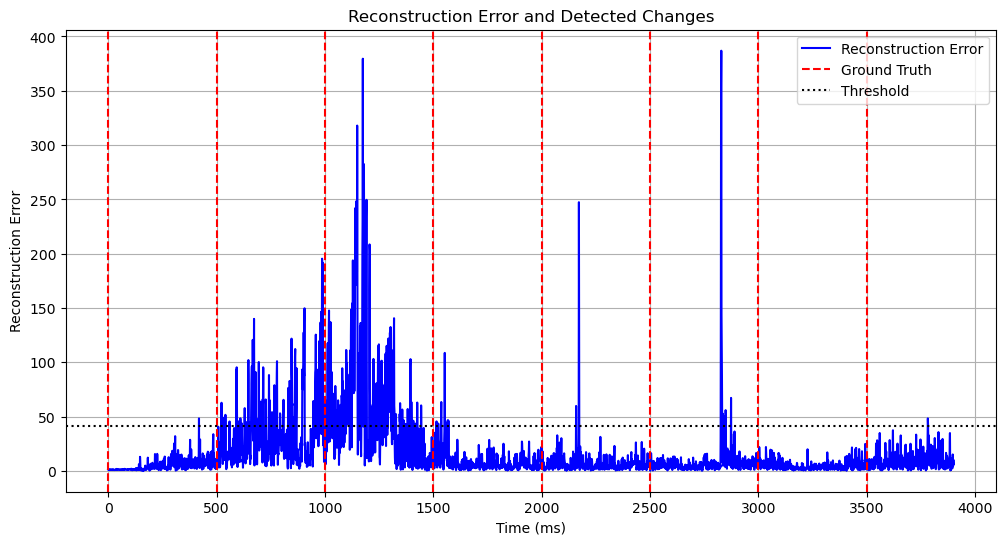

In [51]:
plot_reconstruction_errors2(reconstruction_errors3, detected_changes3, with_changes=False)

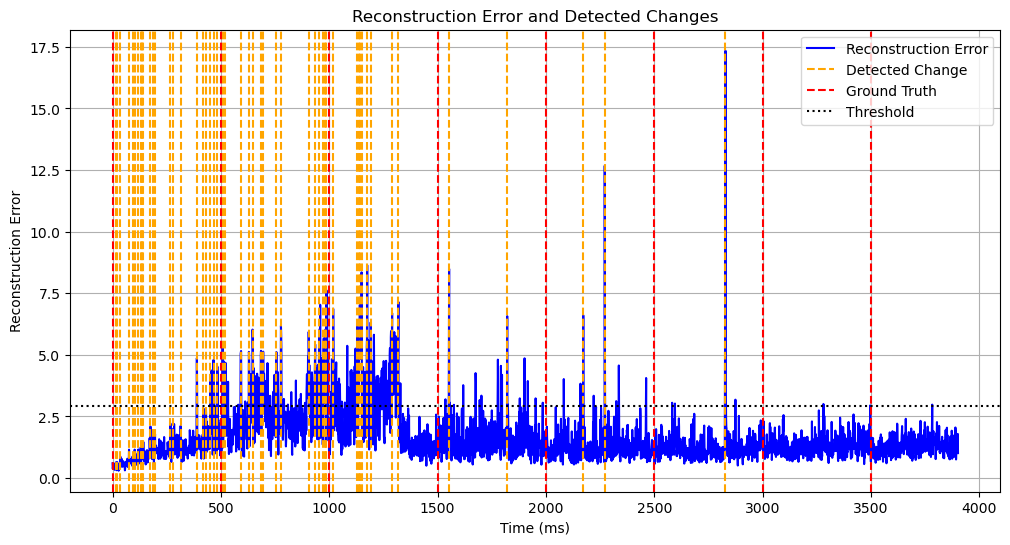

In [26]:
plot_reconstruction_errors2(reconstruction_errors_stiefel2, detected_changes_stiefel2, ground_truth_interval=500)

### 4th TRY

In [65]:
import numpy as np
import matplotlib.pyplot as plt

def stiefel_geodesic_update4(X, grad_X, step_size):
    """
    Perform geodesic update on the Stiefel manifold.
    """
    Q, _ = np.linalg.qr(X + step_size * grad_X)
    return Q

def initialize_covariance_matrices4(xt, yt, n_init_samples):
    """
    Initialize the covariance matrices using the first n_init_samples.
    """
    Cx = np.cov(xt[:n_init_samples], rowvar=False)
    Cy = np.cov(yt[:n_init_samples], rowvar=False)
    Cxy = np.cov(xt[:n_init_samples].T, yt[:n_init_samples].T)[:xt.shape[1], xt.shape[1]:]
    return Cx, Cy, Cxy

def adap_cca_stiefel4(xt, yt, beta=0.98, p=4, threshold_percentile=90, step_size=0.01, n_init_samples=100):
    """
    Adaptive CCA algorithm using gradient ascent on the Generalized Stiefel Manifold.
    """
    n_samples, nx = xt.shape
    _, ny = yt.shape

    # Initialize covariance matrices
    Cx, Cy, Cxy = initialize_covariance_matrices4(xt, yt, n_init_samples)

    # Initialize Ux and Vy on the Stiefel manifold
    Ux = np.random.randn(nx, p)
    Vy = np.random.randn(ny, p)
    Ux, _ = np.linalg.qr(Ux)  # Orthonormalize
    Vy, _ = np.linalg.qr(Vy)

    # Initialize diagonal matrix N
    N = np.diag(np.linspace(1.0, 0.1, p))  # Example: diagonal with decreasing weights

    reconstruction_errors = []
    detected_changes = []

    for t in range(n_samples):
        x_t = xt[t].reshape(-1, 1)
        y_t = yt[t].reshape(-1, 1)

        # Update covariance matrices
        if t >= n_init_samples:
            Cx = beta * Cx + (1 - beta) * x_t @ x_t.T
            Cy = beta * Cy + (1 - beta) * y_t @ y_t.T
            Cxy = beta * Cxy + (1 - beta) * x_t @ y_t.T

        # Compute gradients on Stiefel manifold
        Mx = np.linalg.inv(Cx) @ Cxy @ np.linalg.inv(Cy) @ Cxy.T
        My = np.linalg.inv(Cy) @ Cxy.T @ np.linalg.inv(Cx) @ Cxy

        grad_Ux = 2 * (Mx @ Ux @ N - Ux @ (Ux.T @ Mx @ Ux @ N))
        grad_Vy = 2 * (My @ Vy @ N - Vy @ (Vy.T @ My @ Vy @ N))

        # Update Ux and Vy using geodesic flows on the Stiefel manifold
        Ux = stiefel_geodesic_update(Ux, grad_Ux, step_size)
        Vy = stiefel_geodesic_update(Vy, grad_Vy, step_size)

        # Compute residuals
        rx_t = np.linalg.inv(Cx) @ (np.eye(nx) - Ux @ Ux.T) @ x_t
        ry_t = np.linalg.inv(Cy) @ (np.eye(ny) - Vy @ Vy.T) @ y_t

        # Modify reconstruction error computation
        c_t = 0.5 * (rx_t.T @ Cx @ rx_t / np.trace(Cx) + ry_t.T @ Cy @ ry_t / np.trace(Cy))

        # Decrease step size for stability
        step_size = 0.001

        # Stabilize gradients
        grad_Ux = Mx @ Ux @ N - Ux @ (Ux.T @ Mx @ Ux @ N)
        grad_Ux = grad_Ux - Ux @ (Ux.T @ grad_Ux)  # Project onto tangent space
        grad_Vy = My @ Vy @ N - Vy @ (Vy.T @ My @ Vy @ N)
        grad_Vy = grad_Vy - Vy @ (Vy.T @ grad_Vy)

        # Adaptive thresholding
        # Ensure reconstruction_errors has entries before accessing [-1]
        if len(reconstruction_errors) > 0:
            threshold = np.mean(reconstruction_errors[max(0, len(reconstruction_errors) - 100):]) + \
                        2 * np.std(reconstruction_errors[max(0, len(reconstruction_errors) - 100):])
            if reconstruction_errors[-1] > threshold:
                if len(detected_changes) == 0 or (t - detected_changes[-1] > 5):
                    detected_changes.append(t)
        else:
            # Default case: no detection until reconstruction_errors is populated
            threshold = float('inf')


    return reconstruction_errors, detected_changes

def plot_reconstruction_errors4(reconstruction_errors, detected_changes, ground_truth_interval=500, with_changes=True):
    """
    Plot reconstruction errors with detected and true change points.
    """
    plt.figure(figsize=(12, 6))
    x = np.arange(len(reconstruction_errors))

    # Plot reconstruction errors
    plt.plot(x, reconstruction_errors, label="Reconstruction Error", color='blue')

    # Plot detected changes
    if with_changes:
        for change in detected_changes:
            plt.axvline(change, color='orange', linestyle='--', label="Detected Change" if change == detected_changes[0] else "")

    # Plot ground truth change points
    for truth in range(0, len(reconstruction_errors), ground_truth_interval):
        plt.axvline(truth, color='red', linestyle='dashed', label="Ground Truth" if truth == 0 else "")

    # Add threshold line
    threshold = np.percentile(reconstruction_errors, 90)
    plt.axhline(threshold, color='black', linestyle='dotted', label="Threshold")

    plt.xlabel("Time (ms)")
    plt.ylabel("Reconstruction Error")
    plt.title("Reconstruction Error and Detected Changes")
    plt.legend()
    plt.grid(True)
    plt.show()


In [66]:
r4, d4 = adap_cca_stiefel4(xt, yt, beta=beta, p=p, threshold_percentile=90, step_size=0.01)

IndexError: index -1 is out of bounds for axis 0 with size 0

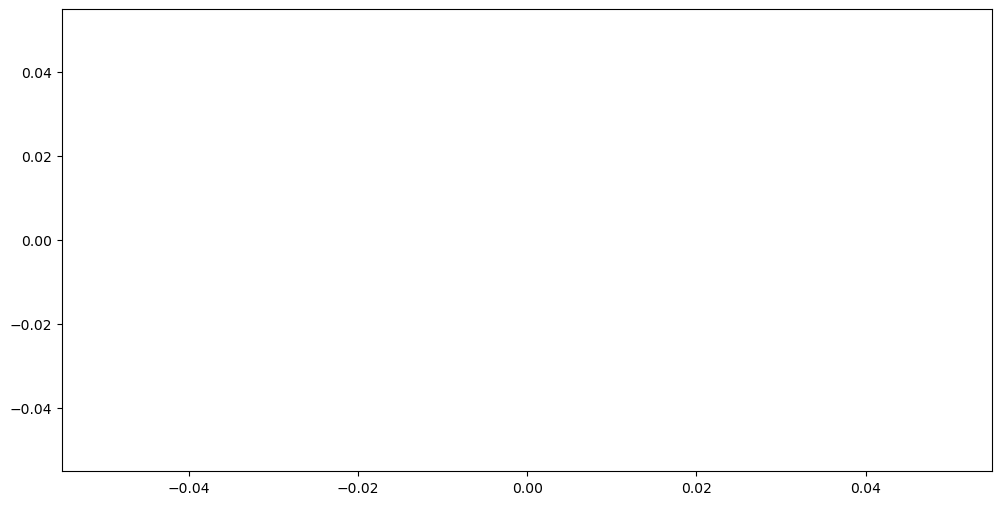

In [67]:
plot_reconstruction_errors4(r4, d4, with_changes=False)

##### **C. Evaluation of the algorithm**

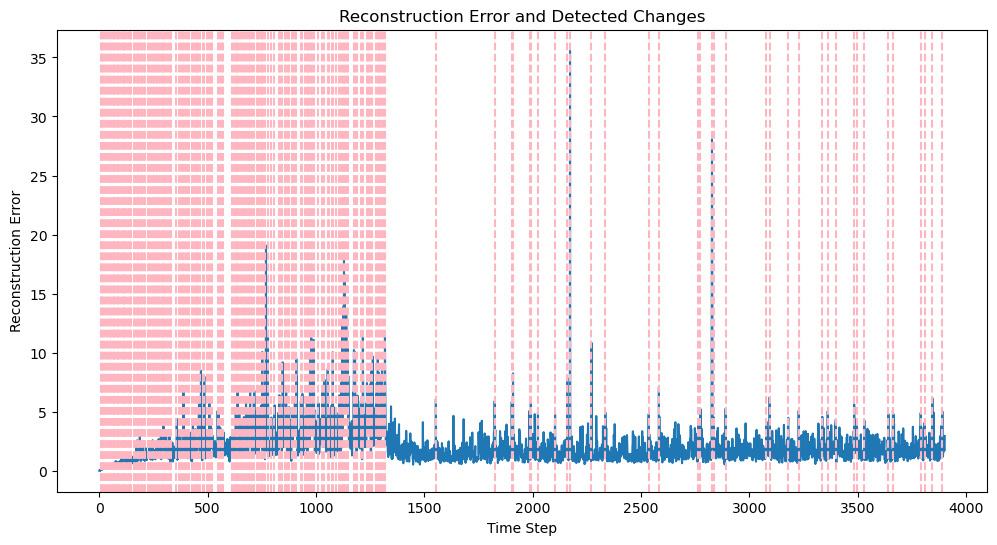

In [142]:
def plot_reconstruction_errors(reconstruction_errors, detected_changes):
    plt.figure(figsize=(12, 6))
    plt.plot(reconstruction_errors, label="Reconstruction Error")
    for change in detected_changes:
        plt.axvline(change, color="lightpink", linestyle="--", label="Detected Change")
    plt.xlabel("Time Step")
    plt.ylabel("Reconstruction Error")
    # plt.legend()
    plt.title("Reconstruction Error and Detected Changes (Standard Adaptive CCA)")
    plt.show()

plot_reconstruction_errors(reconstruction_errors, detected_changes)

In [ ]:
def plot_reconstruction_errors(reconstruction_errors, detected_changes):
    plt.figure(figsize=(12, 6))
    plt.plot(reconstruction_errors, label="Reconstruction Error")
    for change in detected_changes:
        plt.axvline(change, color="lightpink", linestyle="--", label="Detected Change")
    plt.xlabel("Time Step")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    plt.title("Reconstruction Error and Detected Changes (Adaptive Geometric CCA)", fontweight="bold")
    plt.show()

plot_reconstruction_errors(reconstruction_errors_stiefel, detected_changes_stiefel)

NameError: name 'reconstruction_errors_stiefel' is not defined

The blue line represents the reconstruction error over time. The error fluctuates significantly in certain regions, especially in the earlier part of the plot **(between time steps 0-1000**). After this, the reconstruction error tends to stabilize and stays relatively low.

The red dashed lines represent the detected changes. A change is flagged when the reconstruction error exceeds a certain threshold tau (To Define). These changes are likely occurring where the error spikes dramatically, which may be a sign of a **threshold too sensitive.**

In [143]:
# `true_changes` contains ground truth change points
true_changes = []  # TODO: change points
y_true = np.zeros(n_samples)
y_pred = np.zeros(n_samples)

y_true[true_changes] = 1
y_pred[detected_changes] = 1

auc = roc_auc_score(y_true, reconstruction_errors) if true_changes else None
if auc:
    print(f"AUC of Change Detection: {auc:.4f}")
else:
    print("No ground truth change points provided.")

No ground truth change points provided.


##### **D. Performance Test**

##### **D.1:** Syntetic data

In [168]:
import numpy as np

def generate_synthetic_bci_data(nx=36, ny=36, n_samples=1000, change_point=500, noise_level=0.1):
    """
    Generate synthetic data for BCI with a known change point.
    """
    np.random.seed(42)
    
    # Generate independent random data for xt and yt
    xt = np.random.randn(n_samples, nx) + noise_level * np.random.randn(n_samples, nx)
    yt = np.random.randn(n_samples, ny) + noise_level * np.random.randn(n_samples, ny)

    # Introduce correlation before the change point
    for i in range(change_point):
        yt[i] += 0.8 * xt[i]

    # After the change point, reduce correlation
    for i in range(change_point, n_samples):
        yt[i] += 0.2 * xt[i]

    return xt, yt, change_point



In [174]:
import time
import matplotlib.pyplot as plt

def compare_methods(xt, yt, change_point, beta=0.98, p=4, threshold_percentile=90):
    """
    Compare standard adaptive CCA with the geometric approach.
    """
    # Standard Adaptive CCA
    start_time = time.time()
    recon_errors_std, detected_changes_std = adap_cca_synthetic(xt, yt, beta=beta, p=p, threshold_percentile=threshold_percentile)
    runtime_std = time.time() - start_time

    # Geometric Adaptive CCA
    start_time = time.time()
    recon_errors_geom, detected_changes_geom = adap_cca_stiefel(xt, yt, beta=beta, p=p, threshold_percentile=threshold_percentile)
    runtime_geom = time.time() - start_time

    # Visualize Reconstruction Errors
    plt.figure(figsize=(12, 6))
    plt.plot(recon_errors_std, label="Standard Adaptive CCA", color='blue')
    plt.plot(recon_errors_geom, label="Geometric Adaptive CCA", color='orange')
    plt.axvline(change_point, color='red', linestyle='--', label="True Change Point")
    plt.legend()
    plt.xlabel("Time Steps")
    plt.ylabel("Reconstruction Error")
    plt.title("Reconstruction Errors")
    plt.show()

    # Visualize Change Detection
    plt.figure(figsize=(12, 6))
    plt.scatter(detected_changes_std, [1] * len(detected_changes_std), label="Standard Adaptive CCA", color='blue', marker='o')
    plt.scatter(detected_changes_geom, [2] * len(detected_changes_geom), label="Geometric Adaptive CCA", color='orange', marker='x')
    plt.axvline(change_point, color='red', linestyle='--', label="True Change Point")
    plt.yticks([1, 2], ["Standard", "Geometric"])
    plt.legend()
    plt.xlabel("Time Steps")
    plt.title("Change Detection Results")
    plt.show()

    # Print Runtime Comparison
    print(f"Standard Adaptive CCA Runtime: {runtime_std:.4f} seconds")
    print(f"Geometric Adaptive CCA Runtime: {runtime_geom:.4f} seconds")

    # Return results for further analysis
    return {
        "reconstruction_errors_std": recon_errors_std,
        "detected_changes_std": detected_changes_std,
        "runtime_std": runtime_std,
        "reconstruction_errors_geom": recon_errors_geom,
        "detected_changes_geom": detected_changes_geom,
        "runtime_geom": runtime_geom,
    }


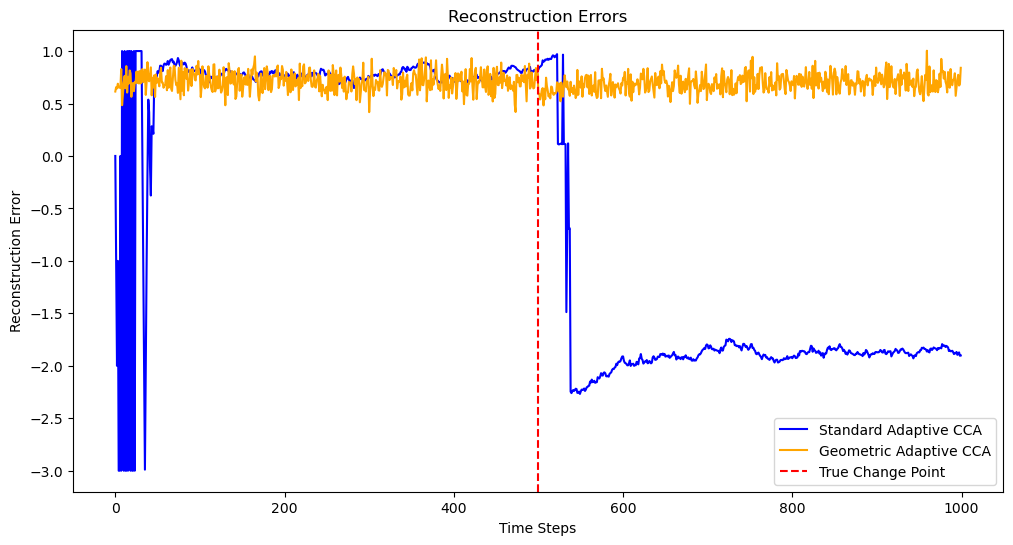

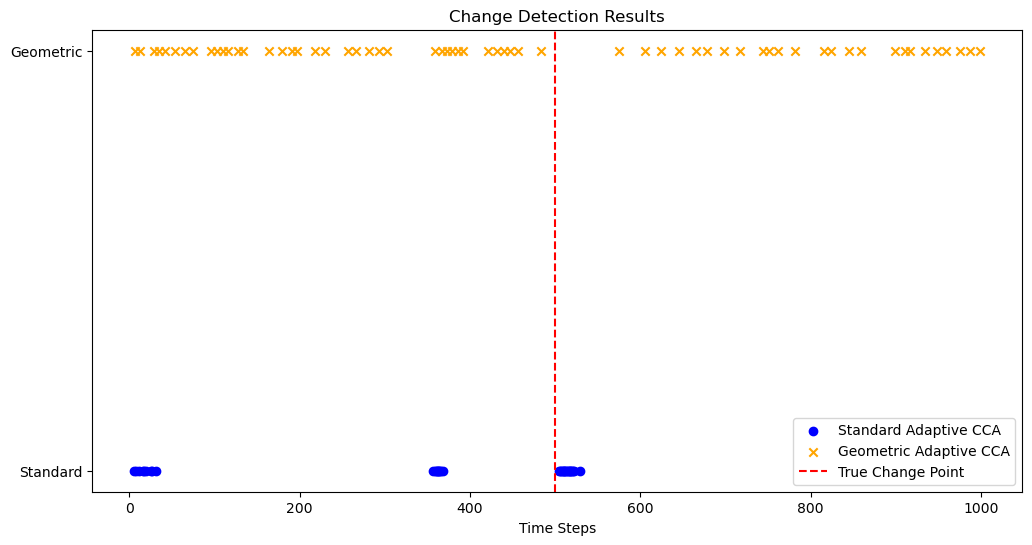

Standard Adaptive CCA Runtime: 3.7093 seconds
Geometric Adaptive CCA Runtime: 9.4832 seconds

Running Geometric Adaptive CCA with step size 0.005


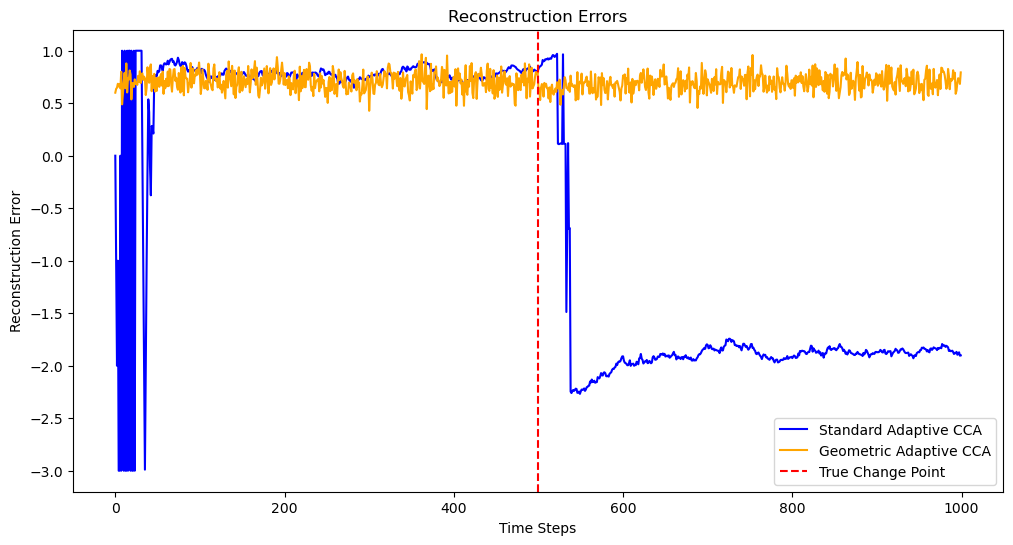

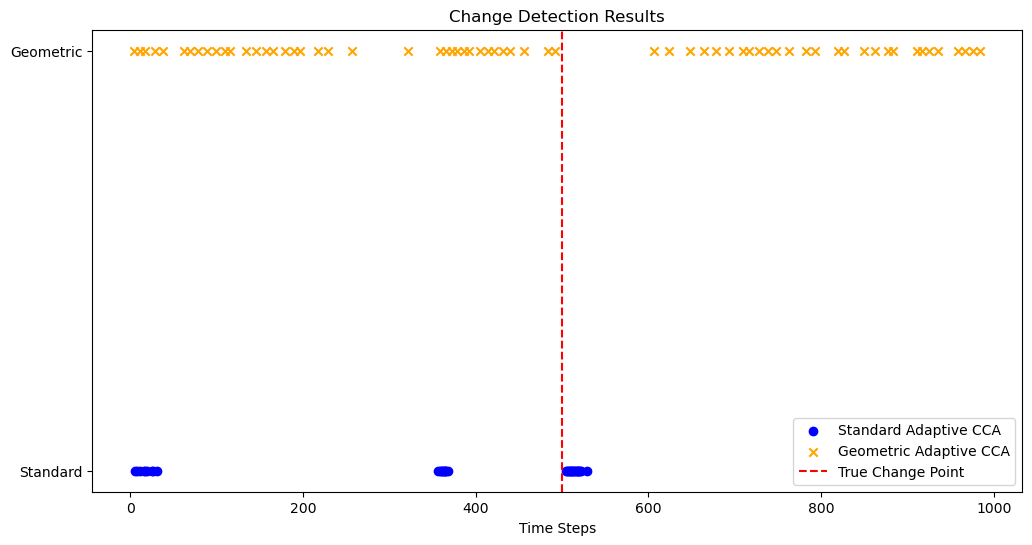

Standard Adaptive CCA Runtime: 3.7513 seconds
Geometric Adaptive CCA Runtime: 9.2559 seconds

Running Geometric Adaptive CCA with step size 0.01


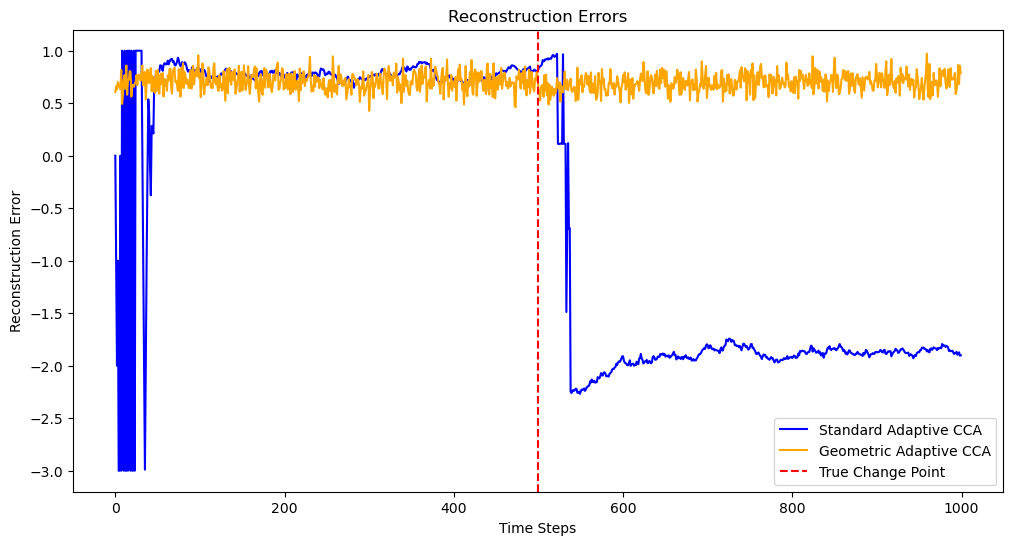

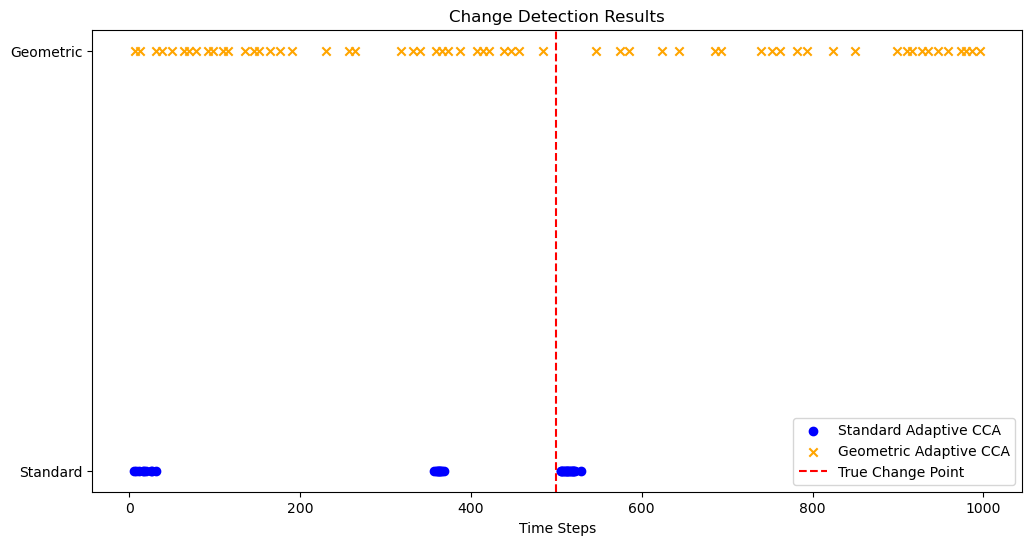

Standard Adaptive CCA Runtime: 3.5510 seconds
Geometric Adaptive CCA Runtime: 9.1638 seconds

Running Geometric Adaptive CCA with step size 0.02


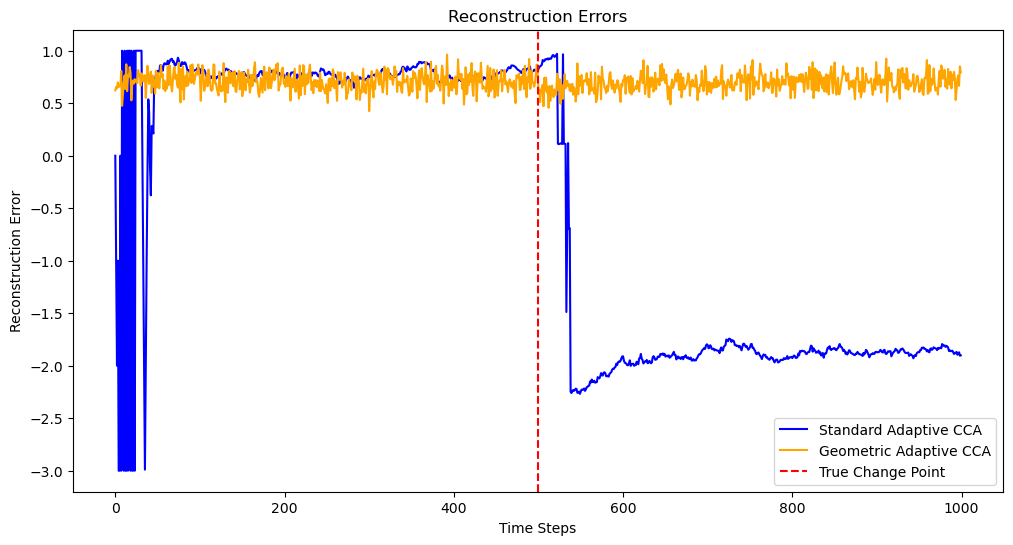

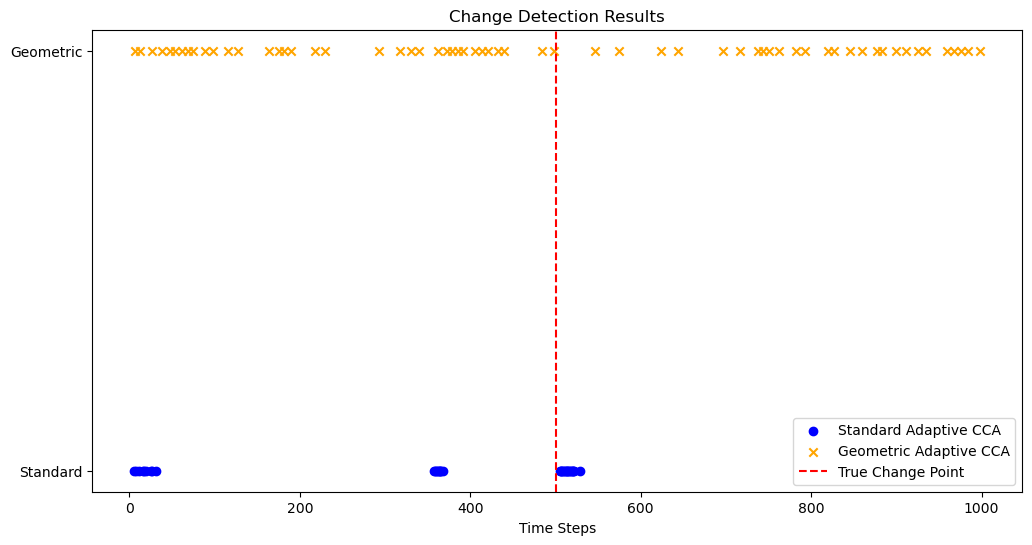

Standard Adaptive CCA Runtime: 3.7429 seconds
Geometric Adaptive CCA Runtime: 10.3129 seconds


In [177]:
# Generate synthetic data
xt, yt, change_point = generate_synthetic_bci_data()

# Compare methods
results = compare_methods(xt, yt, change_point)

# Experiment with different step sizes
for step_size in [0.005, 0.01, 0.02]:
    print(f"\nRunning Geometric Adaptive CCA with step size {step_size}")
    _ = compare_methods(xt, yt, change_point, beta=0.98, p=4, threshold_percentile=90)


##### **E. Further Debugging**

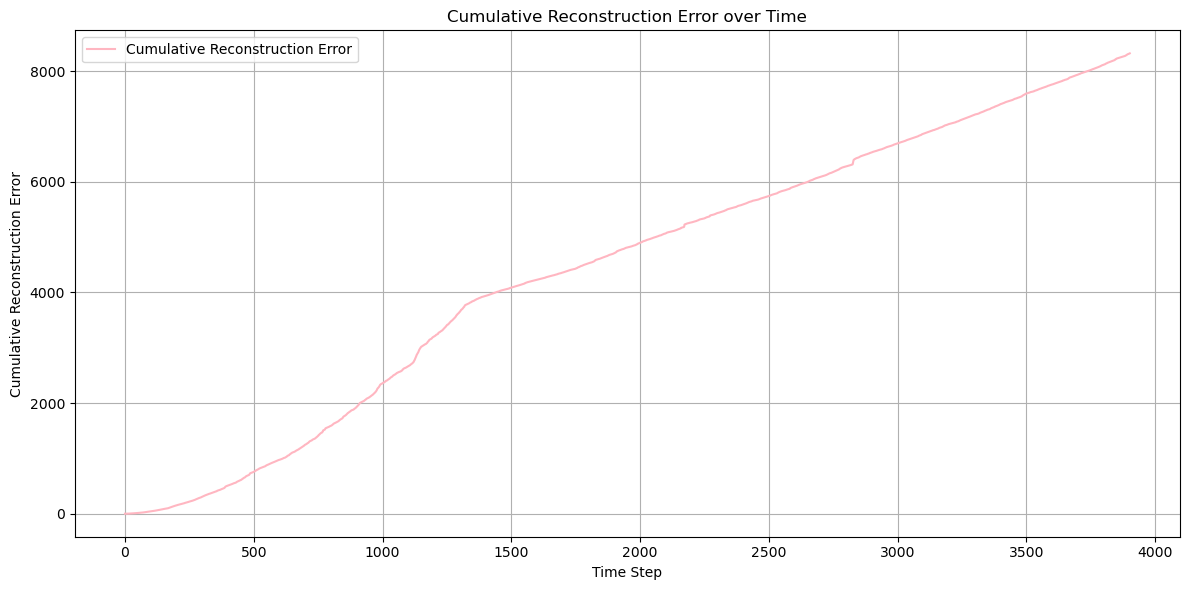

In [144]:
def plot_cumulative_reconstruction_error(reconstruction_errors):
    """
    Plots the cumulative reconstruction error over time.
    """
    cumulative_errors = np.cumsum(reconstruction_errors)
    
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_errors, label='Cumulative Reconstruction Error', color='lightpink')
    plt.xlabel('Time Step')
    plt.ylabel('Cumulative Reconstruction Error')
    plt.title('Cumulative Reconstruction Error over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_cumulative_reconstruction_error(reconstruction_errors)


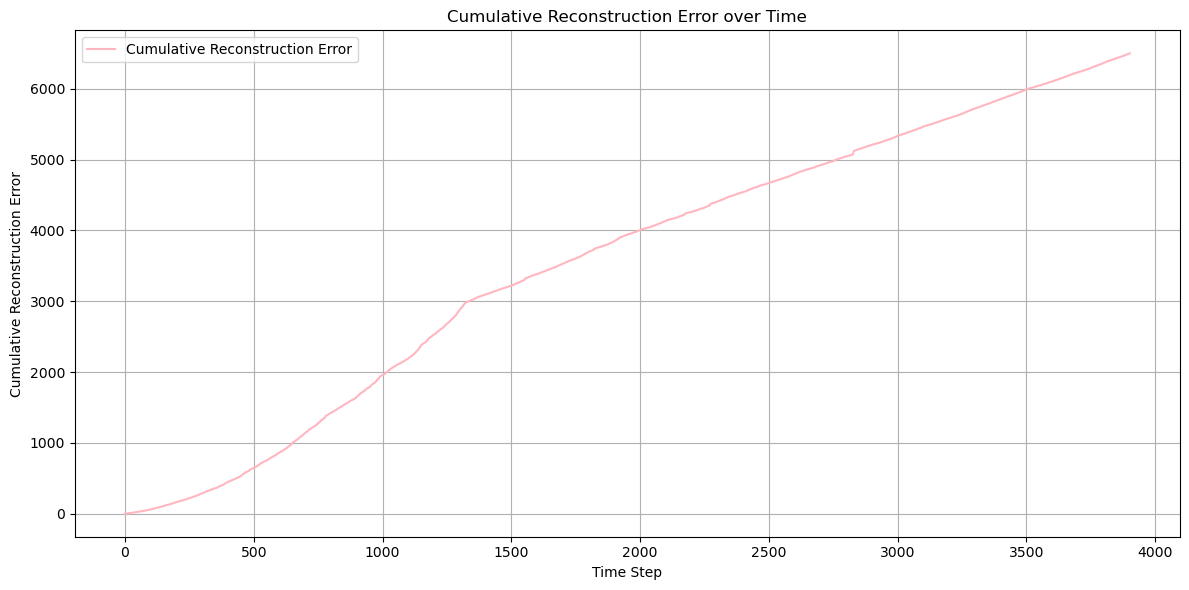

In [154]:
plot_cumulative_reconstruction_error(reconstruction_errors_stiefel)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cumulative_reconstruction_error(reconstruction_errors_stiefel, reconstruction_errors):
    """
    Plots the cumulative reconstruction error over time for both methods on the same graph.
    """
    cumulative_errors_stiefel = np.cumsum(reconstruction_errors_stiefel)
    cumulative_errors = np.cumsum(reconstruction_errors)
  
    plt.figure(figsize=(6, 5))
    plt.plot(cumulative_errors_stiefel, label='Stiefel Manifold Method', color='lightpink')
    plt.plot(cumulative_errors, label='Standard Method', color='lightblue')
    plt.xlabel('Time Step')
    plt.ylabel('Cumulative Reconstruction Error')
    plt.title('Comparison of Cumulative Reconstruction Error over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function with both sets of reconstruction errors
plot_cumulative_reconstruction_error(reconstruction_errors_stiefel, reconstruction_errors)




NameError: name 'reconstruction_errors_stiefel' is not defined

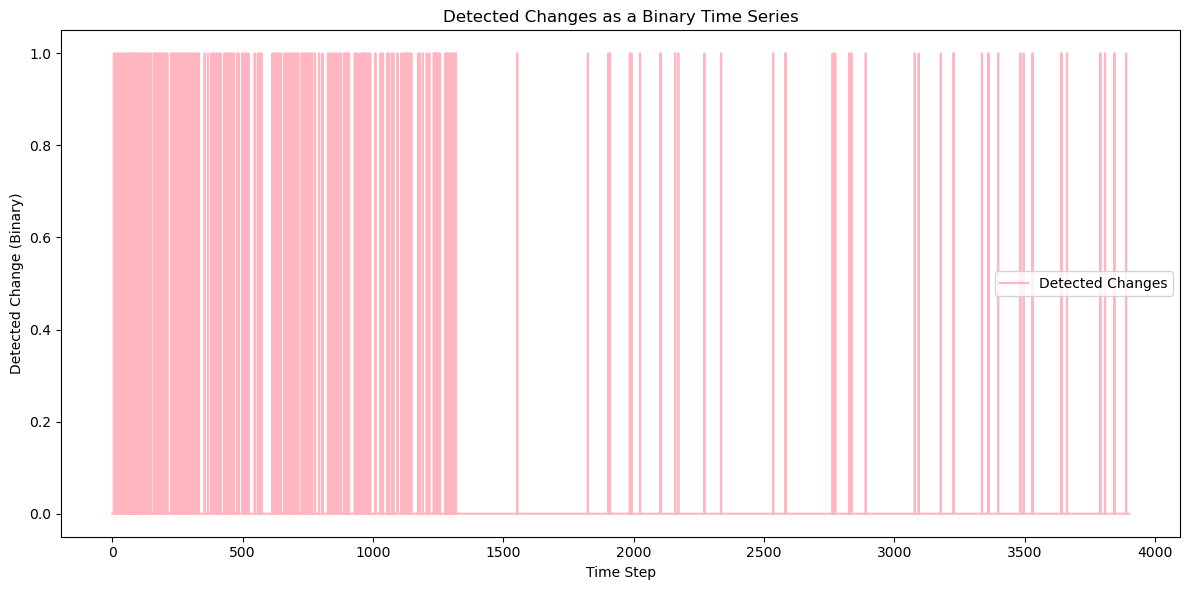

In [145]:
def plot_detected_changes_binary(reconstruction_errors, detected_changes):
    """
    Plots detected changes as a binary time series (0 for no change, 1 for detected change).
    """
    binary_changes = np.zeros_like(reconstruction_errors)
    binary_changes[detected_changes] = 1

    plt.figure(figsize=(12, 6))
    plt.plot(binary_changes, label='Detected Changes', color='lightpink', drawstyle='steps-post')
    plt.xlabel('Time Step')
    plt.ylabel('Detected Change (Binary)')
    plt.title('Detected Changes as a Binary Time Series')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_detected_changes_binary(reconstruction_errors, detected_changes)

IndexError: list index out of range

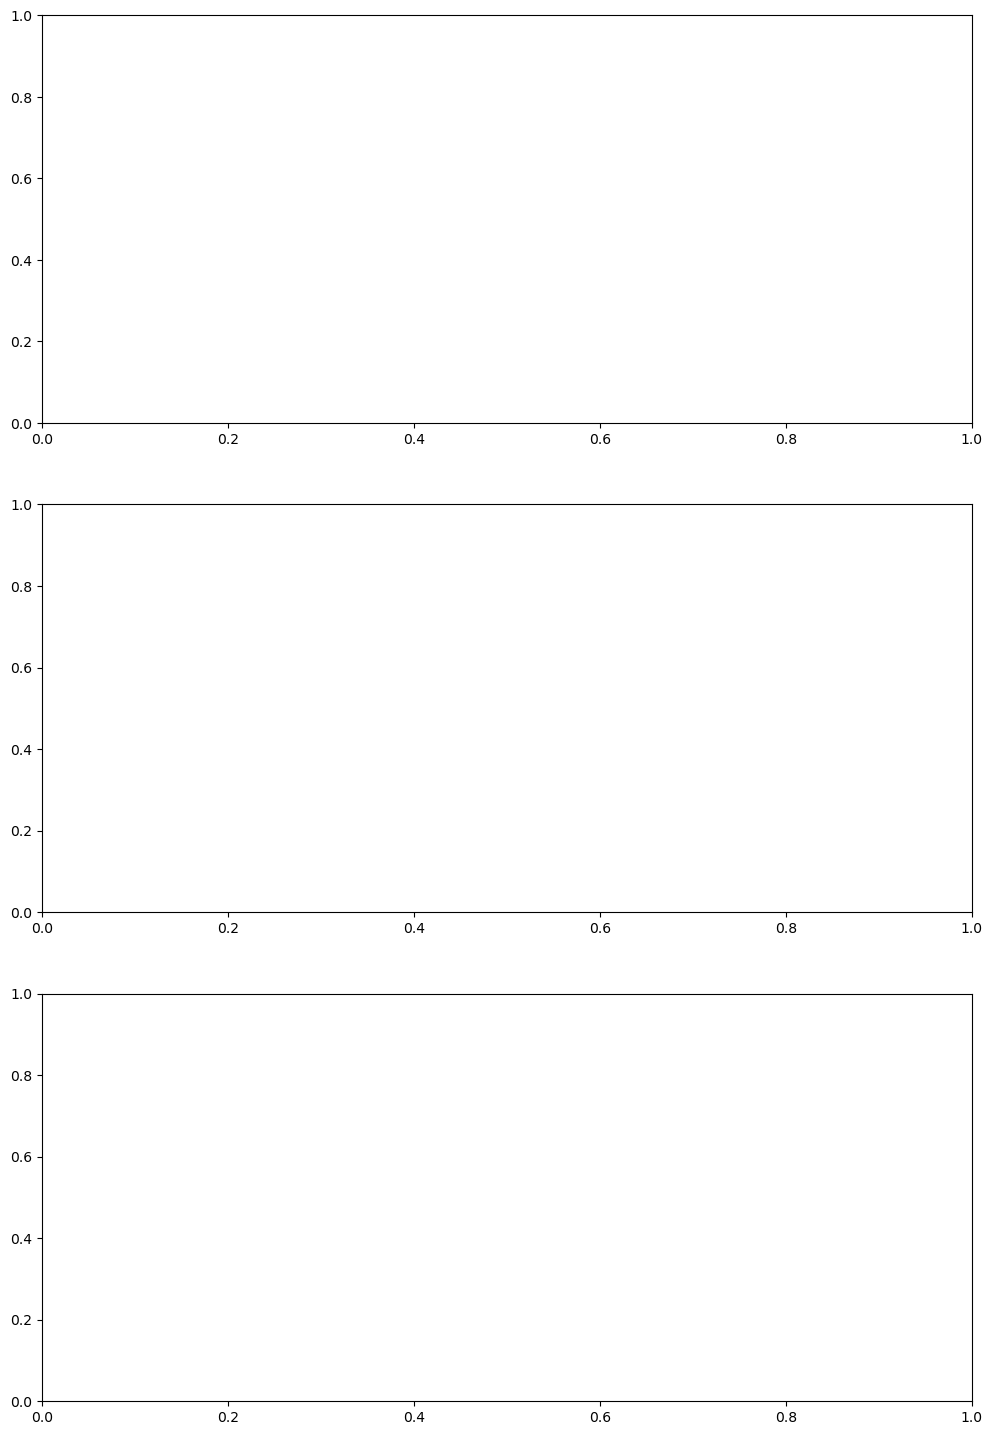

In [146]:
def plot_covariance_matrices(Cx_list, Cy_list, Cxy_list):
    """
    Plots the evolution of the covariance matrices (Cx, Cy, Cxy) over time.
    """
    fig, axes = plt.subplots(3, 1, figsize=(12, 18))

    axes[0].imshow(Cx_list[-1], cmap='hot', aspect='auto')
    axes[0].set_title('Final Covariance Matrix Cx')
    axes[0].set_xlabel('Channels (X)')
    axes[0].set_ylabel('Channels (X)')

    axes[1].imshow(Cy_list[-1], cmap='hot', aspect='auto')
    axes[1].set_title('Final Covariance Matrix Cy')
    axes[1].set_xlabel('Channels (Y)')
    axes[1].set_ylabel('Channels (Y)')

    axes[2].imshow(Cxy_list[-1], cmap='hot', aspect='auto')
    axes[2].set_title('Final Cross-Covariance Matrix Cxy')
    axes[2].set_xlabel('Channels (X)')
    axes[2].set_ylabel('Channels (Y)')

    plt.tight_layout()
    plt.show()

plot_covariance_matrices(Cx_list, Cy_list, Cxy_list)

In [ ]:
def plot_residuals_over_time(residuals_x, residuals_y):
    """
    Plots residuals (rx_t and ry_t) over time.
    """
    plt.figure(figsize=(12, 6))
    
    # Plot residuals for both x and y views
    plt.plot(residuals_x, label='Residuals for X', color='blue')
    plt.plot(residuals_y, label='Residuals for Y', color='orange')
    
    plt.xlabel('Time Step')
    plt.ylabel('Residuals')
    plt.title('Residuals over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_residuals_over_time(residuals_x, residuals_y)

#### **7. Geometric Vs. Standard**

In [ ]:
def standard_cca(xt, yt, p=4):
    """
    Standard CCA algorithm for two datasets xt and yt.
    """
    # Compute covariance matrices
    Cxx = np.cov(xt, rowvar=False)
    Cyy = np.cov(yt, rowvar=False)
    Cxy = np.cov(xt, yt, rowvar=False)[:xt.shape[1], xt.shape[1]:]

    # Solve generalized eigenvalue problem
    eig_vals, eig_vecs_x = np.linalg.eigh(np.linalg.inv(Cxx) @ Cxy @ np.linalg.inv(Cyy) @ Cxy.T)
    eig_vals, eig_vecs_y = np.linalg.eigh(np.linalg.inv(Cyy) @ Cxy.T @ np.linalg.inv(Cxx) @ Cxy)

    # Take top p components
    Ux = eig_vecs_x[:, -p:]
    Vy = eig_vecs_y[:, -p:]

    return Ux, Vy, eig_vals


In [ ]:
import time

start_time = time.time()
Ux, Vy, eig_vals = standard_cca(xt, yt)
standard_cca_time = time.time() - start_time

start_time = time.time()
reconstruction_errors, detected_changes, _, _, _, _, _ = adap_cca(xt, yt)
geometric_cca_time = time.time() - start_time

print(f"Standard CCA Time: {standard_cca_time}")
print(f"Geometric CCA Time: {geometric_cca_time}")
